# Unsupervised POS Induction for Voynich Manuscript

This notebook implements an unsupervised Part-of-Speech (POS) induction pipeline to extract syntactic meaning from the Voynich Manuscript. It uses distributional clustering based on word co-occurrence patterns to infer pseudo-POS categories (e.g., function words, content words) without prior language knowledge. The approach is lightweight, interpretable, and compatible with the `data_exploration.ipynb` framework, leveraging folio-aware cleaning and aligning with metrics like Zipf’s Law.

## Overview
- **Step 1 – Text Preparation**: Clean and tokenize the Voynich text into sentences using folio-aware parsing.
- **Step 2 – Co-occurrence Matrix**: Build a word-context frequency matrix for POS context analysis.
- **Step 3 – Vectorization**: Normalize co-occurrence data with PMI to create word vectors for POS similarity.
- **Step 4 – POS Clustering**: Apply KMeans to group words into pseudo-POS categories.
- **Step 5 – POS Interpretation**: Analyze clusters based on frequency and context diversity to hypothesize POS roles.
- **Step 6 – Evaluation**: Cross-validate POS clusters with frequency data (e.g., low-entropy words).
- **Visualizations**: Tables and plots for co-occurrence, POS clusters, and interpretations.

In [1]:
!pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Dependencies and Setup

In [3]:
# Import Libs
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from typing import Dict, List, Tuple, Optional
from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import nltk

In [4]:
nltk.download('punkt')

# Voynich Manuscript 
VOYNICH_FILE = "transliteration_zl.txt"

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
class VoynichTextProcessor:
    """Processes Voynich Manuscript text with folio-aware cleaning and tokenization."""
    def __init__(self):
        self.digraphs = {'ch', 'sh'}
        self.folio_data = {}
        self.raw_text = None

    def load_raw_text(self, filepath: str) -> bool:
        """Load raw text from file."""
        try:
            with open(filepath, 'r', encoding='utf-8') as f:
                self.raw_text = f.read()
            return True
        except FileNotFoundError:
            print(f"Error: File '{filepath}' not found.")
            return False

    def tokenize_word(self, word: str) -> List[str]:
        """Tokenize a word into characters or digraphs (e.g., 'ch', 'sh')."""
        tokens = []
        i = 0
        while i < len(word):
            if i < len(word) - 1 and word[i:i+2] in self.digraphs:
                tokens.append(word[i:i+2])
                i += 2
            else:
                tokens.append(word[i])
                i += 1
        return tokens

    def parse_all_folios(self, filepath: str, glyph_level: bool = False, treat_commas_as_spaces: bool = True, min_word_length: int = 2) -> Tuple[Dict, List[str], List[List[str]]]:
        """Parse Voynich text into folios and sentences for POS analysis."""
        if not self.load_raw_text(filepath):
            return {}, [], []

        lines = self.raw_text.strip().split('\n')
        current_folio = None
        current_folio_key = None
        folio_pattern = r'<f(\d+)([rv])?\.'
        all_words = []
        sentences = []
        current_sentence = []

        for line in lines:
            line = line.strip()
            if not line or line.startswith('#'):
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
                continue

            cleaned_line = line
            cleaned_line = re.sub(r'@\d+', '', cleaned_line)
            cleaned_line = re.sub(r'<![^>]*>', '', cleaned_line)
            cleaned_line = re.sub(r'<[^>]*>', '', cleaned_line)
            def replace_uncertain(match):
                options = match.group(1).split(':')
                return options[0] if options else ''
            cleaned_line = re.sub(r'\[([^\]]+)\]', replace_uncertain, cleaned_line)
            cleaned_line = re.sub(r'[{}]', '', cleaned_line)
            cleaned_line = re.sub(r'\?+', '', cleaned_line)
            cleaned_line = re.sub(r'[^a-zA-Z\s,.]', '', cleaned_line)
            if treat_commas_as_spaces:
                cleaned_line = cleaned_line.replace('.', ' ').replace(',', ' ')
            else:
                cleaned_line = cleaned_line.replace('.', ' ').replace(',', '')
            cleaned_line = re.sub(r'\s+', ' ', cleaned_line).strip().lower()

            folio_match = re.search(folio_pattern, line)
            if folio_match:
                current_folio = int(folio_match.group(1))
                folio_side = folio_match.group(2) or 'r'
                current_folio_key = f"{current_folio}{folio_side}"
                folio_text = cleaned_line
                if current_sentence:
                    sentences.append(current_sentence)
                    current_sentence = []
            else:
                folio_text = cleaned_line

            if current_folio and folio_text:
                if current_folio_key not in self.folio_data:
                    self.folio_data[current_folio_key] = {
                        'folio_num': current_folio,
                        'folio_side': folio_side,
                        'raw_text': [],
                        'clean_words': [],
                        'clean_glyphs': []
                    }
                self.folio_data[current_folio_key]['raw_text'].append(folio_text)
                if glyph_level:
                    glyphs = list(folio_text)
                    glyphs = [g for g in glyphs if g.isalpha()]
                    self.folio_data[current_folio_key]['clean_glyphs'].extend(glyphs)
                words = folio_text.split()
                clean_words = [w for w in words if re.match(r'^[a-z]+$', w) and len(w) >= min_word_length]
                self.folio_data[current_folio_key]['clean_words'].extend(clean_words)
                all_words.extend(clean_words)
                current_sentence.extend(clean_words)

        if current_sentence:
            sentences.append(current_sentence)

        sentences = [s for s in sentences if len(s) > 1]

        return self.folio_data, all_words, sentences

## Co-occurrence Matrix for POS Context

In [6]:
def build_pos_cooccurrence_matrix(filepath: str) -> Tuple[csr_matrix, List[str], Dict[str, int]]:
    """Build a word-context co-occurrence matrix for POS induction with PMI normalization."""
    processor = VoynichTextProcessor()
    folio_data, all_words, sentences = processor.parse_all_folios(filepath)
    if not all_words:
        return None, [], {}

    # Vocabulary
    word_freq = Counter(all_words)
    vocab = list(word_freq.keys())
    word_to_idx = {word: i for i, word in enumerate(vocab)}

    # Build co-occurrence matrix (left and right contexts)
    cooc_matrix = np.zeros((len(vocab), len(vocab)))
    for sentence in sentences:
        for i in range(len(sentence)):
            word = sentence[i]
            if word not in word_to_idx:
                continue
            # Left context
            if i > 0:
                prev_word = sentence[i-1]
                if prev_word in word_to_idx:
                    cooc_matrix[word_to_idx[word], word_to_idx[prev_word]] += 1
            # Right context
            if i < len(sentence) - 1:
                next_word = sentence[i+1]
                if next_word in word_to_idx:
                    cooc_matrix[word_to_idx[word], word_to_idx[next_word]] += 1
            if i > 1:
                prev2 = sentence[i-2]
                if prev2 in word_to_idx:
                    cooc_matrix[word_to_idx[word], word_to_idx[prev2]] += 0.5
            if i < len(sentence) - 2:
                next2 = sentence[i+2]
                if next2 in word_to_idx:
                    cooc_matrix[word_to_idx[word], word_to_idx[next2]] += 0.5

    # PMI normalization
    total = cooc_matrix.sum()
    row_sums = cooc_matrix.sum(axis=1, keepdims=True)
    col_sums = cooc_matrix.sum(axis=0, keepdims=True)
    pmi_matrix = np.zeros_like(cooc_matrix)
    for i in range(len(vocab)):
        for j in range(len(vocab)):
            if cooc_matrix[i, j] > 0 and row_sums[i] > 0 and col_sums[0, j] > 0:
                pmi = np.log2((cooc_matrix[i, j] * total) / (row_sums[i] * col_sums[0, j]))
                pmi_matrix[i, j] = max(float(pmi), 0)

    # Convert to sparse matrix for efficiency
    cooc_matrix = csr_matrix(pmi_matrix)

    # Visualize sample co-occurrence matrix
    sample_vocab = vocab[:10]
    sample_matrix = pmi_matrix[:10, :10]
    plt.figure(figsize=(8, 6))
    sns.heatmap(sample_matrix, xticklabels=sample_vocab, yticklabels=sample_vocab, cmap='Blues', annot=True, fmt='.2f')
    plt.title('Sample PMI Co-occurrence Matrix for POS Contexts')
    plt.xlabel('Context Word')
    plt.ylabel('Target Word')
    plt.show()

    # Display sample co-occurrence data
    cooc_df = pd.DataFrame([
        {'Word': vocab[i], 'Top POS Context': vocab[np.argmax(pmi_matrix[i])], 'PMI': pmi_matrix[i].max()}
        for i in range(min(10, len(vocab)))
    ])
    print("Sample POS Co-occurrence Data:")
    display(cooc_df)

    return cooc_matrix, vocab, word_to_idx

## POS Clustering and Interpretation

In [7]:
def cluster_and_interpret_pos(filepath: str, num_clusters: int = 10) -> Tuple[Dict[str, int], Dict]:
    """Cluster words and interpret clusters as POS categories based on frequency and context diversity."""
    cooc_matrix, vocab, word_to_idx = build_pos_cooccurrence_matrix(filepath)
    if cooc_matrix is None:
        return {}, {}

    # Dimensionality reduction with TruncatedSVD before clustering
    n_components = min(100, len(vocab) - 1)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    dense_matrix = svd.fit_transform(cooc_matrix.toarray())
    
    # Cluster words for POS induction
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(dense_matrix)
    pos_clusters = {word: label for word, label in zip(vocab, cluster_labels)}

    # Compute frequency and context diversity for POS interpretation
    processor = VoynichTextProcessor()
    folio_data, all_words, sentences = processor.parse_all_folios(filepath)
    word_freq = Counter(all_words)
    context_diversity = {word: np.sum(cooc_matrix[word_to_idx[word]] > 0) for word in vocab}

    # Interpret POS clusters
    pos_cluster_stats = defaultdict(lambda: {'words': [], 'avg_freq': 0, 'avg_diversity': 0})
    for word, cluster in pos_clusters.items():
        pos_cluster_stats[cluster]['words'].append(word)
        pos_cluster_stats[cluster]['avg_freq'] += word_freq[word]
        pos_cluster_stats[cluster]['avg_diversity'] += context_diversity[word]
    for cluster in pos_cluster_stats:
        pos_cluster_stats[cluster]['avg_freq'] /= len(pos_cluster_stats[cluster]['words'])
        pos_cluster_stats[cluster]['avg_diversity'] /= len(pos_cluster_stats[cluster]['words'])
        # Hypothesize POS role based on frequency and diversity
        avg_freq = pos_cluster_stats[cluster]['avg_freq']
        avg_diversity = pos_cluster_stats[cluster]['avg_diversity']
        if avg_freq > np.percentile(list(word_freq.values()), 90):
            pos_cluster_stats[cluster]['pos_role'] = 'Function Words'
        elif avg_diversity > np.percentile(list(context_diversity.values()), 80):
            pos_cluster_stats[cluster]['pos_role'] = 'Content Words (Diverse Contexts)'
        elif len(pos_cluster_stats[cluster]['words']) < 10:
            pos_cluster_stats[cluster]['pos_role'] = 'Rare/Specialized Words'
        else:
            pos_cluster_stats[cluster]['pos_role'] = 'Content Words'

    # Visualize POS cluster distribution
    pos_cluster_counts = Counter(pos_clusters.values())
    plt.figure(figsize=(8, 5))
    plt.bar(pos_cluster_counts.keys(), pos_cluster_counts.values(), color='skyblue')
    plt.xlabel('POS Cluster ID')
    plt.ylabel('Number of Words')
    plt.title('POS Cluster Distribution')
    plt.show()

    # Display POS cluster interpretation
    pos_cluster_df = pd.DataFrame([
        {
            'POS Cluster': f'Cluster {k}',
            'Sample Words': ', '.join(pos_cluster_stats[k]['words'][:5]),
            'Word Count': len(pos_cluster_stats[k]['words']),
            'Avg Frequency': round(pos_cluster_stats[k]['avg_freq'], 2),
            'Avg Context Diversity': round(pos_cluster_stats[k]['avg_diversity'], 2),
            'Hypothesized POS Role': pos_cluster_stats[k]['pos_role']
        }
        for k in pos_cluster_stats
    ])
    print("POS Cluster Interpretation:")
    display(pos_cluster_df)

    return pos_clusters, pos_cluster_stats

## POS Evaluation

In [8]:
def evaluate_pos_clusters(filepath: str, pos_clusters: Dict, pos_cluster_stats: Dict) -> Dict:
    """Evaluate POS clusters against frequency and entropy data."""
    processor = VoynichTextProcessor()
    folio_data, all_words, sentences = processor.parse_all_folios(filepath)
    if not all_words:
        return {}

    # Compute word frequencies and entropy
    word_freq = Counter(all_words)
    total_words = sum(word_freq.values())
    word_probs = {word: freq / total_words for word, freq in word_freq.items()}
    entropy = {word: -prob * np.log2(prob) if prob > 0 else 0 for word, prob in word_probs.items()}
    low_entropy_words = {word for word, ent in entropy.items() if ent < np.percentile(list(entropy.values()), 10)}

    # Evaluate POS clusters
    pos_evaluation = {}
    for cluster in pos_cluster_stats:
        words = set(pos_cluster_stats[cluster]['words'])
        low_entropy_in_cluster = len(words & low_entropy_words)
        pos_evaluation[cluster] = {
            'low_entropy_words': low_entropy_in_cluster,
            'proportion_low_entropy': low_entropy_in_cluster / len(words) if words else 0,
            'pos_role': pos_cluster_stats[cluster]['pos_role']
        }

    # Display evaluation
    pos_eval_df = pd.DataFrame([
        {
            'POS Cluster': f'Cluster {k}',
            'Low Entropy Words': v['low_entropy_words'],
            'Proportion Low Entropy': round(v['proportion_low_entropy'], 2),
            'Hypothesized POS Role': v['pos_role']
        }
        for k, v in pos_evaluation.items()
    ])
    print("POS Cluster Evaluation (Low Entropy Words):")
    display(pos_eval_df)

    return pos_evaluation

## POS Analysis and Outputs

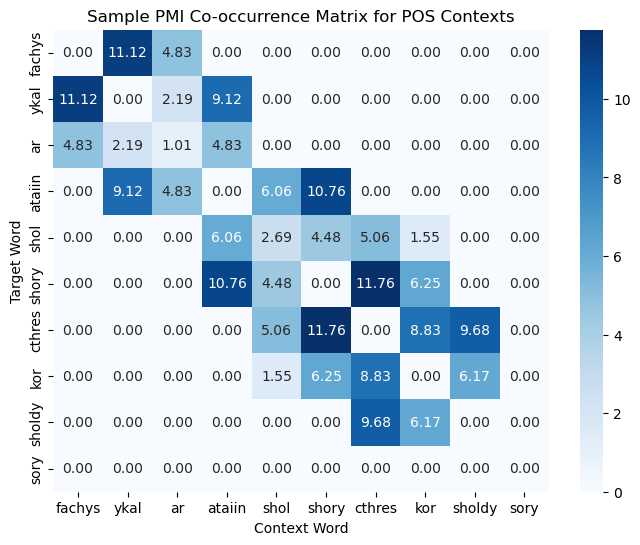

Sample POS Co-occurrence Data:


,Word,Top POS Context,PMI
0,fachys,ykal,11.124614
1,ykal,fachys,11.124614
2,ar,adam,6.414299
3,ataiin,shory,10.762044
4,shol,potoy,7.064690
5,shory,qokchocthor,12.025078
6,cthres,shory,11.762044
7,kor,cholfy,9.096971
8,sholdy,doldydoldaiin,11.684041
9,sory,ckhar,12.844506


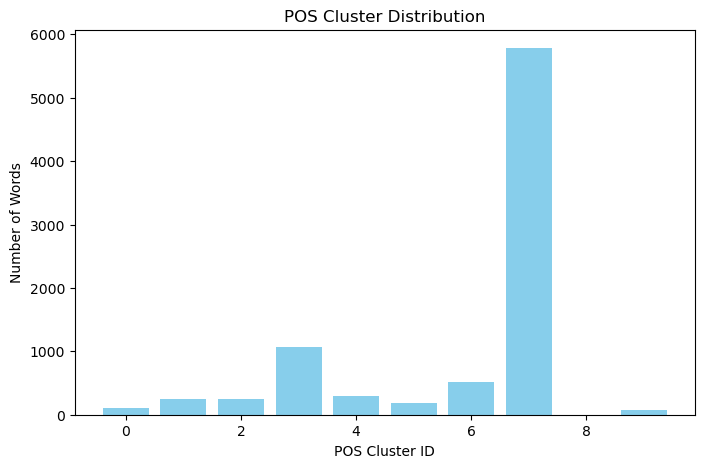

POS Cluster Interpretation:


,POS Cluster,Sample Words,Word Count,Avg Frequency,Avg Context Diversity,Hypothesized POS Role
0,Cluster 7,"fachys, ataiin, shory, cthres, sory",5783,1.23,3.68,Content Words
1,Cluster 6,"ykal, daraiin, roloty, cthiar, cphar",522,1.76,5.53,Content Words
2,Cluster 0,"ar, shar, ykaiin, okaiin, shody",111,83.05,166.89,Function Words
3,Cluster 9,"shol, or, sheky, oteey, chear",75,110.61,203.08,Function Words
4,Cluster 4,"kor, sholdy, cy, otchol, shodan",292,3.20,9.38,Content Words (Diverse Contexts)
5,Cluster 3,"kair, cthar, shod, soiin, oteos",1061,5.35,16.15,Function Words
6,Cluster 1,"sy, okchey, ochol, kdchy, dcheo",242,4.41,13.36,Content Words (Diverse Contexts)
7,Cluster 8,daiin,1,798.00,960.00,Function Words
8,Cluster 2,"cthaiin, chor, kos, ckhey, pshol",249,5.58,15.16,Function Words
9,Cluster 5,"odar, sh, chocthy, chy, kchy",188,7.71,21.76,Function Words


POS Cluster Evaluation (Low Entropy Words):


,POS Cluster,Low Entropy Words,Proportion Low Entropy,Hypothesized POS Role
0,Cluster 7,0,0.0,Content Words
1,Cluster 6,0,0.0,Content Words
2,Cluster 0,0,0.0,Function Words
3,Cluster 9,0,0.0,Function Words
4,Cluster 4,0,0.0,Content Words (Diverse Contexts)
5,Cluster 3,0,0.0,Function Words
6,Cluster 1,0,0.0,Content Words (Diverse Contexts)
7,Cluster 8,0,0.0,Function Words
8,Cluster 2,0,0.0,Function Words
9,Cluster 5,0,0.0,Function Words


POS Induction Results Summary:


,Metric,Value
0,num_pos_clusters,10
1,pos_cluster_distribution,"{'Cluster 7': 5783, 'Cluster 6': 522, 'Cluster..."
2,sample_pos_clusters,"{'Cluster 7': ['fachys', 'ataiin', 'shory', 'c..."
3,hypothesized_pos_roles,"{'Cluster 7': 'Content Words', 'Cluster 6': 'C..."
4,pos_low_entropy_evaluation,"{'Cluster 7': 0.0, 'Cluster 6': 0.0, 'Cluster ..."


In [9]:
def analyze_pos_results(pos_clusters: Dict, pos_cluster_stats: Dict, pos_evaluation: Dict) -> Dict:
    """Summarize POS induction results for decoding."""
    results = {
        'num_pos_clusters': len(pos_cluster_stats),
        'pos_cluster_distribution': {f'Cluster {k}': len(v['words']) for k, v in pos_cluster_stats.items()},
        'sample_pos_clusters': {f'Cluster {k}': v['words'][:5] for k, v in pos_cluster_stats.items()},
        'hypothesized_pos_roles': {f'Cluster {k}': v['pos_role'] for k, v in pos_cluster_stats.items()},
        'pos_low_entropy_evaluation': {f'Cluster {k}': v['proportion_low_entropy'] for k, v in pos_evaluation.items()}
    }

    # Display summary
    results_df = pd.DataFrame([
        {'Metric': k, 'Value': str(v)[:100] + ('...' if len(str(v)) > 100 else '')}
        for k, v in results.items()
    ])
    print("POS Induction Results Summary:")
    display(results_df)

    return results

# Run analysis
pos_clusters, pos_cluster_stats = cluster_and_interpret_pos(VOYNICH_FILE)
pos_evaluation = evaluate_pos_clusters(VOYNICH_FILE, pos_clusters, pos_cluster_stats)
results = analyze_pos_results(pos_clusters, pos_cluster_stats, pos_evaluation)